# Cellpose-SAM: superhuman generalization for cellular segmentation

Marius Pachitariu, Michael Rariden, Carsen Stringer

[paper](https://www.biorxiv.org/content/10.1101/2025.04.28.651001v1) | [code](https://github.com/MouseLand/cellpose)

This notebook explains processing example 2D and 3D images using the Cellpose package on Google Colab using the GPU.

### Make sure you have GPU access enabled by going to Runtime -> Change Runtime Type -> Hardware accelerator and selecting GPU

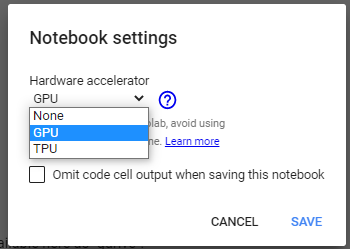

### Install Cellpose-SAM

Check GPU and instantiate model - will download weights.

In [1]:
import numpy as np
from cellpose import models, core, io, plot
from pathlib import Path
from tqdm import trange
import matplotlib.pyplot as plt

io.logger_setup() # run this to get printing of progress
model = models.CellposeModel(gpu=True)



Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.4 
platform:       	linux 
python version: 	3.10.12 
torch version:  	2.7.1+cu126! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 


2025-10-12 12:02:50,922 [INFO] WRITING LOG OUTPUT TO /home/jupyter-pakoh4/.cellpose/run.log
2025-10-12 12:02:50,922 [INFO] 
cellpose version: 	4.0.4 
platform:       	linux 
python version: 	3.10.12 
torch version:  	2.7.1+cu126
2025-10-12 12:02:51,268 [INFO] ** TORCH CUDA version installed and working. **
2025-10-12 12:02:51,269 [INFO] >>>> using GPU (CUDA)
2025-10-12 12:02:52,832 [INFO] >>>> loading model /home/jupyter-pakoh4/.cellpose/models/cpsam


Import Images

In [2]:

import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage import io  

# Specify the folder containing your images
folder_path = "brightfield" 
output_dir  = "masks"
os.makedirs(output_dir, exist_ok=True)
# Find all TIF files in that folder (adjust the extension if needed)
image_files = sorted(glob.glob(os.path.join(folder_path, "*.tif")))
if not image_files:
    raise ValueError(f"No files found in folder: {folder_path}")

# Load images from the folder into a list
imgs = []
for file in image_files:
    img = io.imread(file)
    imgs.append(img)
print(image_files)

['brightfield/F2F_100ms_1%621_001.tif', 'brightfield/F2F_100ms_1%621_002.tif', 'brightfield/F2F_100ms_1%621_003.tif', 'brightfield/FN_100ms_1%621_004.tif', 'brightfield/FN_100ms_1%621_005.tif', 'brightfield/FN_100ms_1%621_006.tif', 'brightfield/FS_100ms_1%621_010.tif', 'brightfield/FS_100ms_1%621_011.tif', 'brightfield/FS_100ms_1%621_012.tif', 'brightfield/agar1000nM017.tif', 'brightfield/agar1000nM018.tif', 'brightfield/agar1000nM019.tif', 'brightfield/agar1000nM020.tif', 'brightfield/chamber1µM004.tif', 'brightfield/chamber1µM005.tif', 'brightfield/chamber1µM006.tif']


### Run Cellpose-SAM

In [3]:
masks_pred, flows, styles = model.eval(imgs, niter=2000,flow_threshold=1) # using more iterations for bacteria
from cellpose import io
io.save_masks(imgs, masks_pred, flows, image_files,
              png=False,
              tif=True,
              savedir=output_dir,
              save_flows=False,
              save_outlines=True)

2025-10-12 12:06:37,708 [INFO] 100%|##########| 16/16 [03:41<00:00, 13.85s/it]


plot results

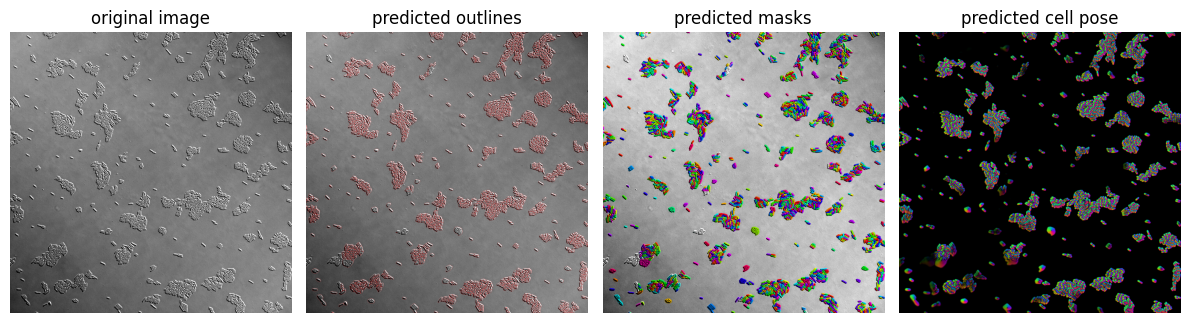

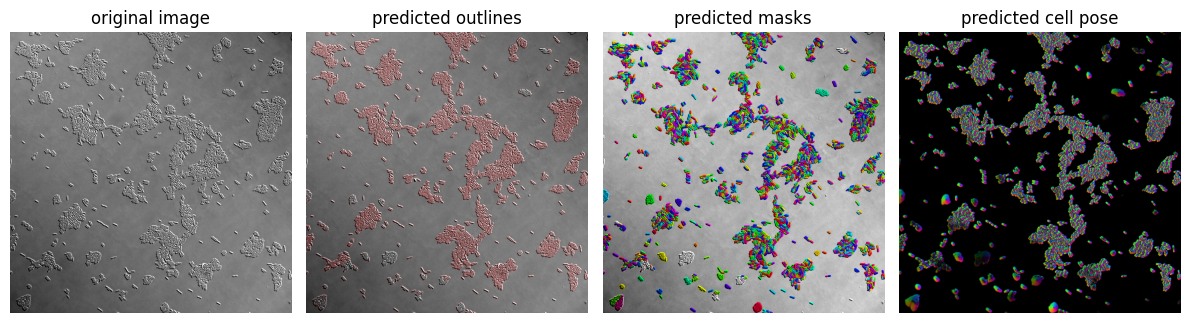

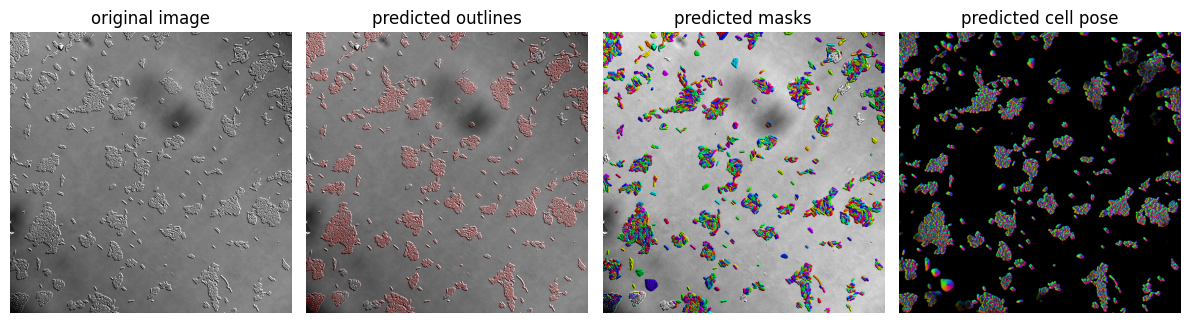

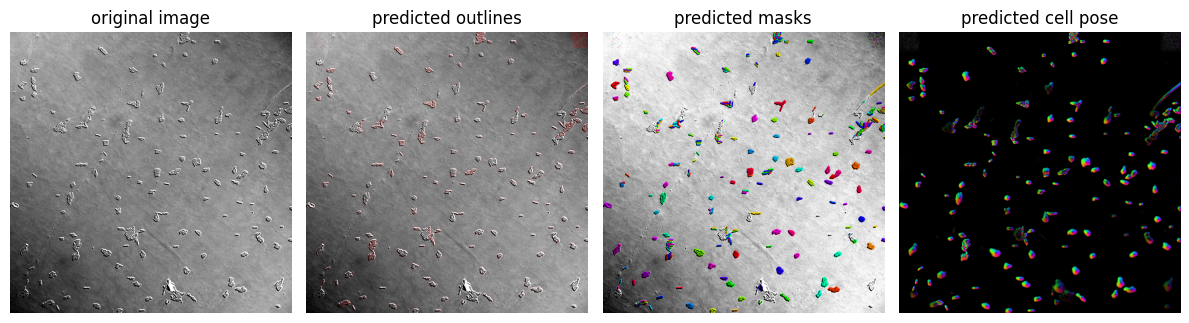

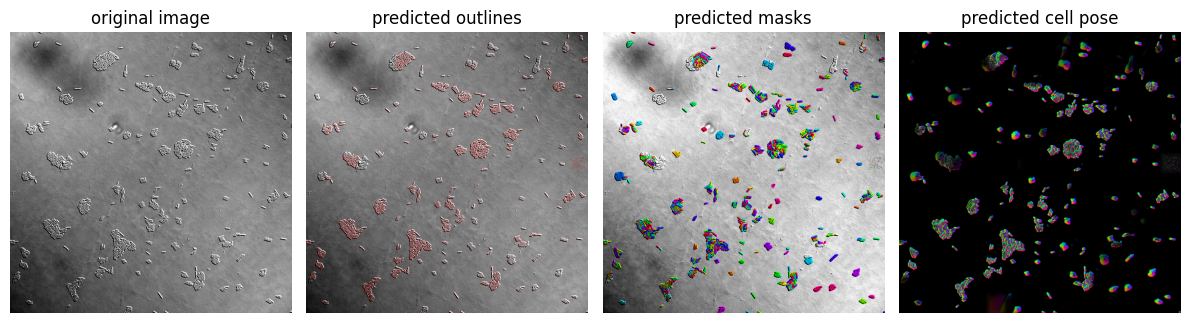

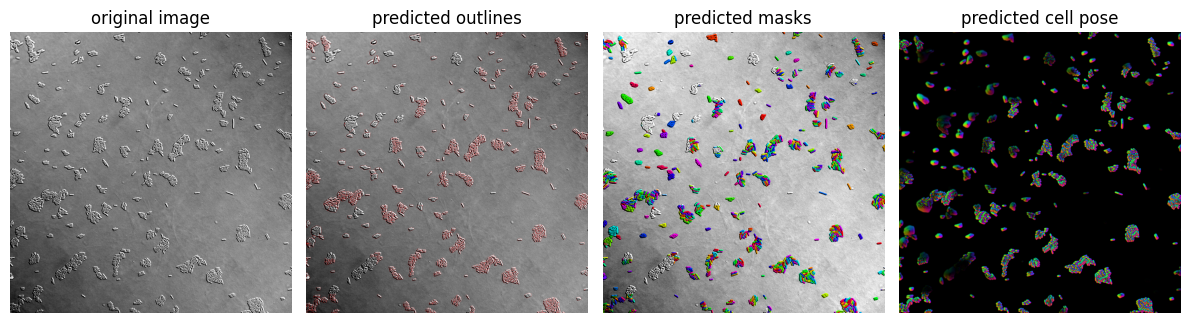

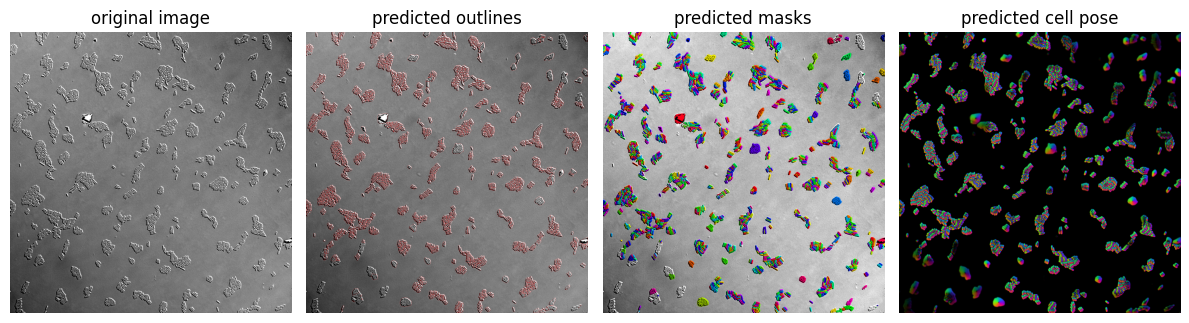

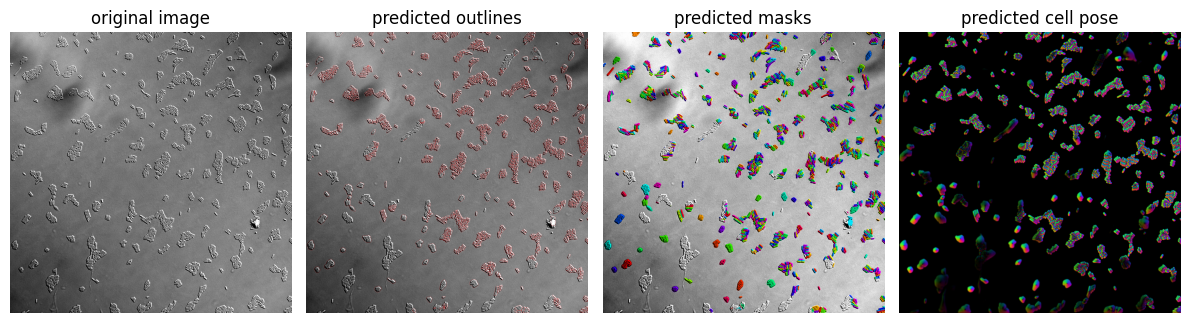

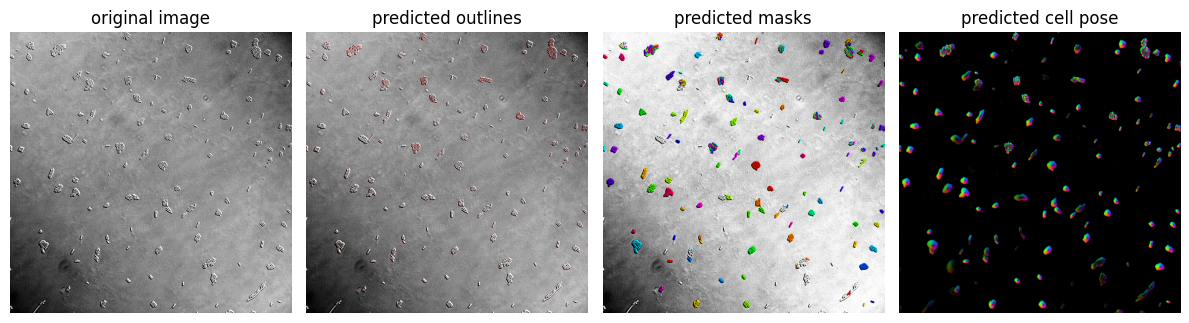

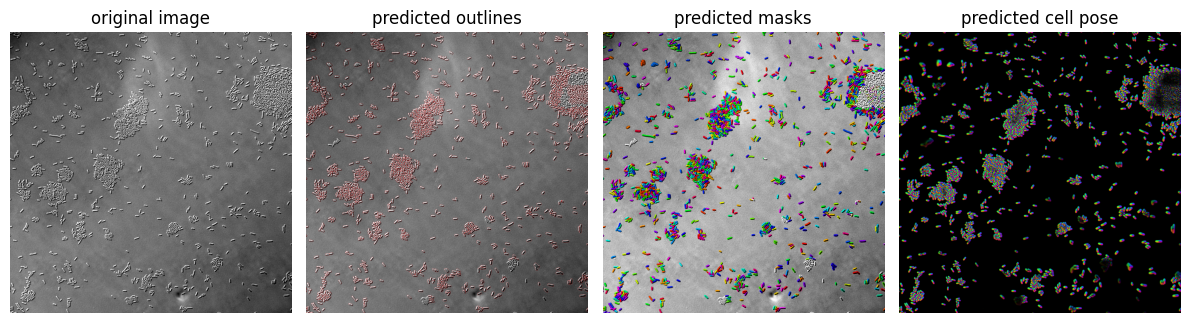

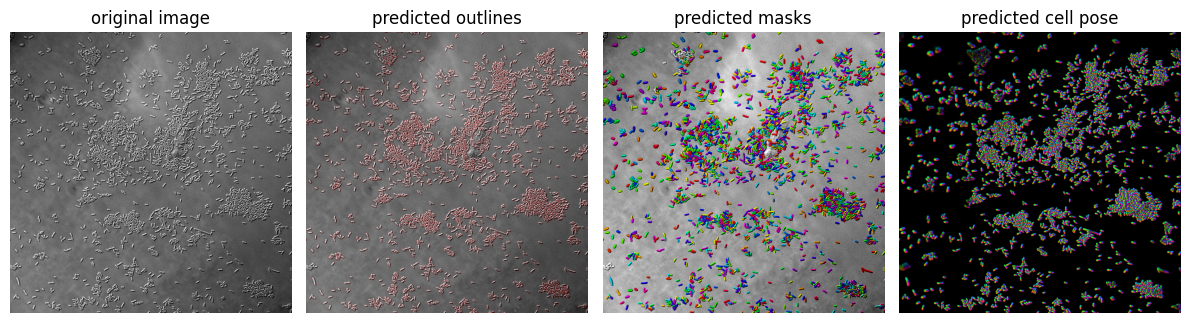

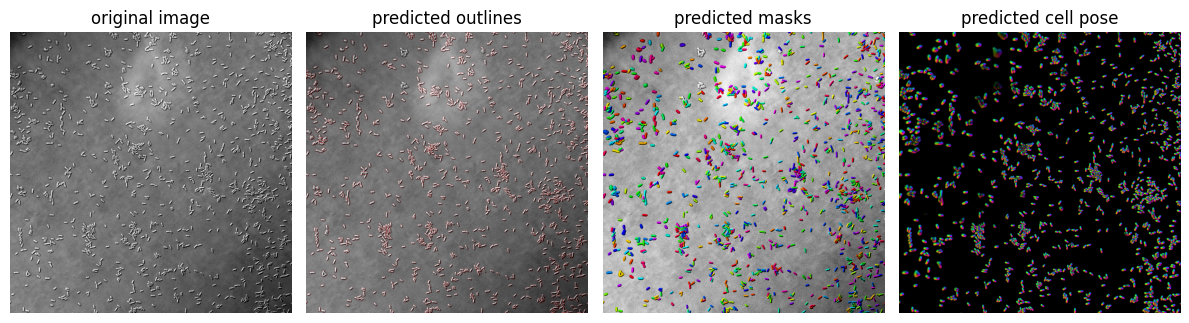

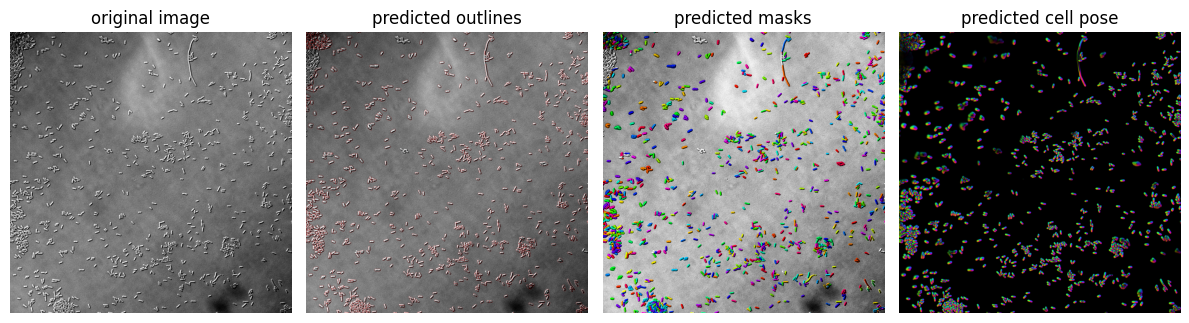

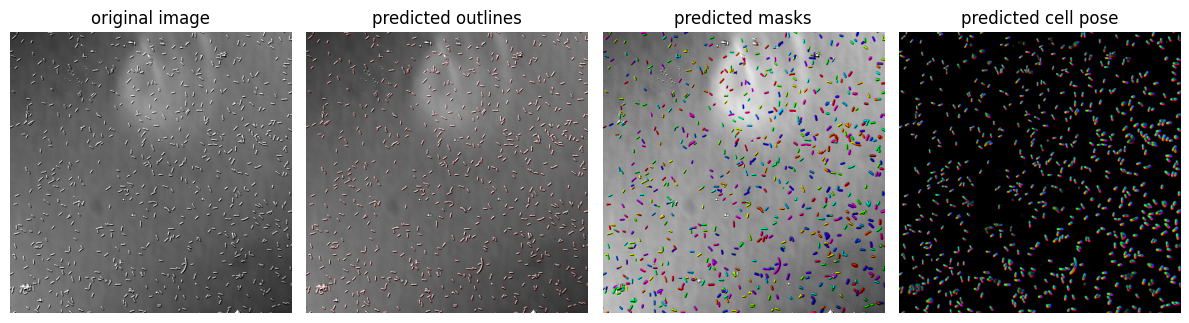

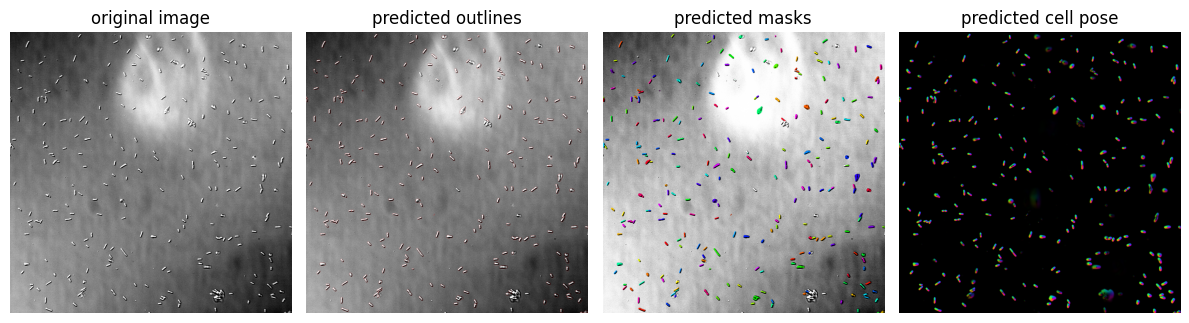

In [4]:
from cellpose import plot

nimg = len(imgs)
for idx in range(nimg):
    maski = masks_pred[idx]
    flowi = flows[idx][0]

    fig = plt.figure(figsize=(12,5))
    plot.show_segmentation(fig, imgs[idx], maski, flowi)
    plt.tight_layout()
    plt.show()

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from cellpose import transforms, utils

plt.figure(figsize=(12, 6))

for iex in range(len(imgs)):
    # Get a copy of the image and remove singleton dimensions
    img = imgs[iex].squeeze().copy()
    
    # If the image is only 2D (i.e. grayscale) then add a channel dimension at axis 0.
    if img.ndim == 2:
        img = np.expand_dims(img, axis=0)
        
    # Normalize the image across the channel axis (axis=0)
    img = np.clip(transforms.normalize_img(img, axis=0), 0, 1)
    
    ax = plt.subplot(3, 8, (iex % 3) * 8 + (iex // 3) + 1)
    
    # If the image has only one channel or the second channel is empty, display as grayscale.
    if img.shape[0] == 1 or (img.shape[0] > 1 and np.all(img[1] == 0)):
        # Use the first channel for grayscale display.
        ax.imshow(img[0], cmap="gray")
    else:
        # For multi-channel images: prepend a dummy channel to create an RGB image.
        # Create a zeros channel with same H/W as the image.
        zeros_channel = np.zeros_like(img[:1])
        # Concatenate the zeros channel with the original channels.
        rgb_img = np.concatenate((zeros_channel, img), axis=0)
        # Transpose from (channels, height, width) to (height, width, channels).
        rgb_img = rgb_img.transpose(1, 2, 0)
        ax.imshow(rgb_img)
    
    # Set display limits based on the height and width (assumed to be the last two dims)
    h, w = img.shape[-2], img.shape[-1]
    # Draw ground-truth outlines in purple and predicted outlines in yellow.
    outlines_pred = utils.outlines_list(masks_pred[iex])
    for o in outlines_pred:
        plt.plot(o[:, 0], o[:, 1], color="green", lw=0.75, ls="--")
    plt.axis('off')
    
    #if iex % 3 == 0:
        #ax.set_title(titles[iex // 3])
plt.show()
